In [27]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from PIL import Image
import os
from tqdm import tqdm
import random
import tensorflow as tf

### 1. Image Augmentation

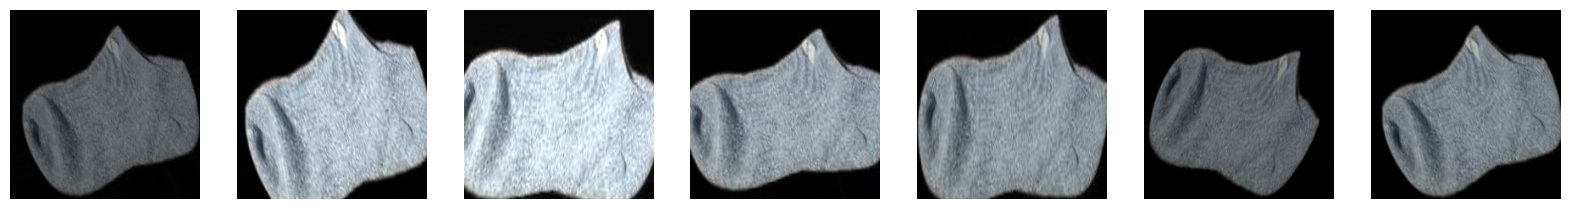

In [28]:
# TODO: Maybe remove rotation later
# TODO: Maybe remove horizontal flip later

np_img = np.array(Image.open("../1Data-Collection/Manual/Centered/IMG_0569.jpg").resize((224, 224)))
np_img = np_img.reshape(1, np_img.shape[0], np_img.shape[1], np_img.shape[2])

# Augumentation Configuration
roating_range = 30
# width_shift_range = 0.05
# height_shift_range = 0.05
width_shift_range = 0
height_shift_range = 0
brightness_range = [0.5, 1.3]
shear_range = 0
zoom_range = 0.15
channel_shift_range =10
horizontal_flip = False
vertical_flip = False

datagen = ImageDataGenerator(rotation_range=roating_range, width_shift_range=width_shift_range, height_shift_range=height_shift_range, brightness_range=brightness_range, shear_range=shear_range, zoom_range=zoom_range, channel_shift_range=channel_shift_range, horizontal_flip=horizontal_flip, vertical_flip=vertical_flip)

aug_iter = datagen.flow(np_img, batch_size=1)

# Show augmented images variation
plt.figure(figsize=(20, 20))
for i in range(7):
    plt.subplot(1, 7, i+1)
    plt.axis("off")
    plt.imshow(aug_iter.next().squeeze().astype(np.uint8))  



In [29]:
def generateAugumentedImages(img, imageCnt):
    aug_iter = datagen.flow(img, batch_size=1)
    images = []

    for i in range(imageCnt):
        images.append(aug_iter.next().astype(np.uint8))
    return np.array(images)

### 2. Prepare the data

In [30]:
def load_images(shape, seed=1234, dataDir="../1Data-Collection/Manual/Socks_Organized/centered/"):
  # Get all images
  random.seed(seed)

  folders = os.listdir(dataDir)
  random.shuffle(folders)

  images = []

  for folder in folders:
      temp = []
      for img in os.listdir(dataDir + folder):
          temp.append(dataDir + folder + "/" + img)
      images.append(temp)

  # Load to numpy array
  np_images = []
  for folder in tqdm(images):
      temp = []
      for img in folder:
          temp.append(np.array(Image.open(img).resize((shape[0], shape[1]))))
      
      np_images.append(np.array(temp))

  return np_images

### 3. Transfer Learning

In [31]:
def featureExtractor(model, shape, augCnt, preprocess_input, dataDir="../1Data-Collection/Manual/Centered/"):
  # Load images
  print("\nLoading Images...")
  np_img = load_images(shape, dataDir)

  # Augumentation
  print ("\nAugmenting Images...")
  aug_imgs = []
  for i in tqdm(range(len(np_img))):
    temp = []
    for j in range(np_img[i].shape[0]):
      temp.append(generateAugumentedImages(np.expand_dims(np_img[i][j], axis=0), augCnt))
    aug_imgs.append(np.array(temp))

  print("Augmented Images Shape:", len(aug_imgs), aug_imgs[0].shape, aug_imgs[1].shape)

  # Preprocess
  print("\nPreprocessing Images...")
  preprocessed = []
  for i in tqdm(range(len(aug_imgs))):
    temp = []
    for j in range(aug_imgs[i].shape[0]):
      temp.append(preprocess_input(aug_imgs[i][j]))
    preprocessed.append(np.array(temp))

  # Extract features
  print("\nExtracting Features...")
  features = []

  for i in tqdm(range(len(preprocessed))):
    temp = []
    for j in range(preprocessed[i].shape[0]):
      temp.append(model.predict(preprocessed[i][j].squeeze(), verbose=0))
    features.append(np.array(temp))
    
  print("Features Shape:", len(features), features[0].shape, features[1].shape)

  return features, aug_imgs

### 4. Preparing the extracted features and labels

In [32]:
def split_data(features, aug_imgs, test_ratio = 0.15, val_ratio = 0.15, seed=1234):
  # Split data
  random.seed(seed)
  randomize = np.arange(len(features))
  random.shuffle(randomize)

  features_rand = []
  aug_imgs_rand = []

  for i in randomize:
    features_rand.append(features[i])
    aug_imgs_rand.append(aug_imgs[i])

  val_cnt = int(len(features_rand) * val_ratio)
  testCnt = int(len(features_rand) * test_ratio)
  trainCnt = int(len(features_rand) * val_ratio)

  val_features = features_rand[:val_cnt]
  val_imgs = aug_imgs_rand[:val_cnt]

  test_features = features_rand[val_cnt:val_cnt+testCnt]
  test_imgs = aug_imgs_rand[val_cnt:val_cnt+testCnt]

  train_features = features_rand[val_cnt+testCnt:]
  train_imgs = aug_imgs_rand[val_cnt+testCnt:]
  

  return train_features, train_imgs, val_features, val_imgs, test_features, test_imgs


In [33]:
# This function take either train or test data and generate pairs and non-pairs
# TODO: This could be super memory intensive. Maybe we should generate pairs/non-pairs on the fly?
def getTrainTest(data, imgs, type, seed=1234):
  X = []
  y = []

  pairImages = []
  imgCnt = 100

  number_of_pairs = 0

  # Generating Pairs
  print("\nGenerating Pairs...")
  for i in tqdm(range(len(data))): # For each socks
    for j in range(data[i].shape[0]):
      for k in range(data[i].shape[0]): # TODO: You can make it j+1 to avoid duplicate pairs 
        for l in range(data[i][j].shape[0]):
          for m in range(data[i][k].shape[0]):
            X.append([data[i][j][l], data[i][k][m]])
            y.append(1)
            number_of_pairs += 1

            if number_of_pairs <= imgCnt:
              img1 = (imgs[i][j][l].squeeze()).astype(np.uint8)
              img2 = (imgs[i][k][m].squeeze()).astype(np.uint8)

              # join images sizeways to one image
              img = np.concatenate((img1, img2), axis=1)

              pairImages.append(img)


  # Load images to tensorboard
  with tf.summary.create_file_writer(f"../2PreparingData/logs/{type}/pair/").as_default():
    tf.summary.image("Pair", np.array(pairImages), max_outputs=100, step=0)

  
  nonPair_X = []

  # Generating Non-Pairs
  print(f"\nGenerating {number_of_pairs} Non-Pairs...")

  number_of_non_pairs = 0
  random.seed(seed)

  while number_of_non_pairs != number_of_pairs:
    sock1, sock2 = random.sample(range(len(data)), 2)
    img1 = random.sample(range(data[sock1].shape[0]), 1)[0]
    img2 = random.sample(range(data[sock2].shape[0]), 1)[0]

    aug1 = random.sample(range(data[sock1][img1].shape[0]), 1)[0]
    aug2 = random.sample(range(data[sock2][img2].shape[0]), 1)[0]

    X.append([data[sock1][img1][aug1], data[sock2][img2][aug2]])
    y.append(0)

    number_of_non_pairs += 1

    if number_of_non_pairs <= imgCnt:
      img1 = (imgs[sock1][img1][aug1].squeeze()).astype(np.uint8)
      img2 = (imgs[sock2][img2][aug2].squeeze()).astype(np.uint8)

      # join images sizeways to one image
      img = np.concatenate((img1, img2), axis=1)

      nonPair_X.append(img)

      
  # Load images to tensorboard
  with tf.summary.create_file_writer(f"../2PreparingData/logs/{type}/nonpair/").as_default():
    tf.summary.image("Non-Pair", np.array(nonPair_X), max_outputs=100, step=0)

  X = np.array(X)
  y = np.array(y)

  return X, y

### 5. Use pre-trained model as a feature extractor

In [34]:
from keras.applications import VGG16, MobileNetV2, VGG19
# from keras.applications.vgg16 import preprocess_input
from keras.applications.mobilenet_v2 import preprocess_input
# from keras.applications.vgg19 import preprocess_input as preprocess_input_vgg19


# Load MobileNetV2
mobilenet = MobileNetV2(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
# vgg16 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3), pooling='max')
# vgg19 = VGG19(include_top=False, weights="imagenet", input_shape=(224, 224, 3), pooling='max')

In [35]:
features, aug_imgs = featureExtractor(mobilenet, (224, 224), 3, preprocess_input)


Loading Images...


  5%|▍         | 3/62 [00:00<00:02, 28.68it/s]

100%|██████████| 62/62 [00:01<00:00, 48.46it/s]



Augmenting Images...


100%|██████████| 62/62 [00:15<00:00,  3.98it/s]


Augmented Images Shape: 62 (4, 3, 1, 224, 224, 3) (4, 3, 1, 224, 224, 3)

Preprocessing Images...


100%|██████████| 62/62 [00:00<00:00, 109.00it/s]



Extracting Features...


100%|██████████| 62/62 [00:54<00:00,  1.14it/s]

Features Shape: 62 (4, 3, 7, 7, 1280) (4, 3, 7, 7, 1280)


In [36]:
train, trainImg, val, valImg, test, testImg = split_data(features, aug_imgs)

train_X, train_y = getTrainTest(train, trainImg, "train")
val_X, val_y = getTrainTest(val, valImg, "val")
test_X, test_y = getTrainTest(test, testImg, "test")

print("Train X Shape:", train_X.shape)
print("Train y Shape:", train_y.shape)
print("Val X Shape:", val_X.shape)
print("Val y Shape:", val_y.shape)
print("Test X Shape:", test_X.shape)
print("Test y Shape:", test_y.shape)


Generating Pairs...


100%|██████████| 44/44 [00:00<00:00, 902.92it/s]



Generating 6516 Non-Pairs...

Generating Pairs...


100%|██████████| 9/9 [00:00<00:00, 381.27it/s]



Generating 1296 Non-Pairs...

Generating Pairs...


100%|██████████| 9/9 [00:00<00:00, 360.88it/s]



Generating 1458 Non-Pairs...
Train X Shape: (13032, 2, 7, 7, 1280)
Train y Shape: (13032,)
Val X Shape: (2592, 2, 7, 7, 1280)
Val y Shape: (2592,)
Test X Shape: (2916, 2, 7, 7, 1280)
Test y Shape: (2916,)


### 6. Export data to npy files

In [37]:
np.save("../3ModelTraining/train_X.npy", train_X)
np.save("../3ModelTraining/train_y.npy", train_y)
np.save("../3ModelTraining/val_X.npy", val_X)
np.save("../3ModelTraining/val_y.npy", val_y)
np.save("../3ModelTraining/test_X.npy", test_X)
np.save("../3ModelTraining/test_y.npy", test_y)

: 